In [1]:
# Marco Montez
# GitHub: MarcoAntonioMontez
# December 2019

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None
from sklearn.cluster import KMeans

In [2]:
raw_data = pd.read_csv("training_data.csv")
display(raw_data.head())

,MANDT,BUKRS,GJAHR,HKONT,KUNNR,PRCTR,KNA1_LAND1,KNA1_ORT01,ZTERM,DUE_DATE_SOURCE,...,TBSLT_LTEXT,MANSP,CTLPC,HISTORICRATING,CURRENTRATING,DATUM,DUE_DATE,GJAHR2,DOCUMENT_DATE,PAYMENT_DATE
0,310,3,2018,11,18724,1,NL,KATWIJK,63,ZBD2T,...,Invoice,NaN,NaN,NaN,NaN,2017-12-01,2017-12-23,2019,1.512086e+15,20180109
1,310,3,2018,11,19521,1,NL,WARNSVELD,63,ZBD2T,...,Invoice,NaN,NaN,NaN,NaN,2018-01-02,2018-01-10,2016,1.514851e+15,20180109
2,310,3,2018,11,5420,1,NL,OSS,63,ZBD2T,...,Invoice,NaN,NaN,NaN,NaN,2017-12-01,2017-12-27,2019,1.512086e+15,20180109
3,310,3,2018,11,18724,1,NL,KATWIJK,63,ZBD2T,...,Invoice,NaN,NaN,NaN,NaN,2018-01-02,2018-01-27,2016,1.514851e+15,20180109
4,310,3,2018,11,5420,1,NL,OSS,63,ZBD2T,...,Invoice,NaN,NaN,NaN,NaN,2018-01-02,2018-01-07,2016,1.514851e+15,20180109


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266093 entries, 0 to 266092
Data columns (total 25 columns):
MANDT              266093 non-null int64
BUKRS              266093 non-null int64
GJAHR              266093 non-null int64
HKONT              266093 non-null int64
KUNNR              266093 non-null int64
PRCTR              266093 non-null int64
KNA1_LAND1         266093 non-null object
KNA1_ORT01         266093 non-null object
ZTERM              266093 non-null int64
DUE_DATE_SOURCE    266093 non-null object
VALUE_EUR          266093 non-null int64
MWSTS              266093 non-null float64
MWST2              266093 non-null float64
BLART              266093 non-null object
T003T_LTEXT        266093 non-null object
TBSLT_LTEXT        266093 non-null object
MANSP              7619 non-null object
CTLPC              153913 non-null float64
HISTORICRATING     160122 non-null object
CURRENTRATING      160121 non-null object
DATUM              266093 non-null object
DUE_DATE      

In [4]:
data = raw_data.copy()
data['PAYMENT_DATE'] = data['PAYMENT_DATE'].astype('str').apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:]).astype('datetime64[ns]')
data['DUE_DATE']= data['DUE_DATE'].astype('datetime64[ns]')
timestamp_df = (data['DOCUMENT_DATE']/(10**6)).astype(np.int64)
data['DOCUMENT_DATE']=pd.to_datetime(timestamp_df, unit='s')

C:\Users\marco\.conda\envs\DataScience\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Percentage samples removed: 6.2069%


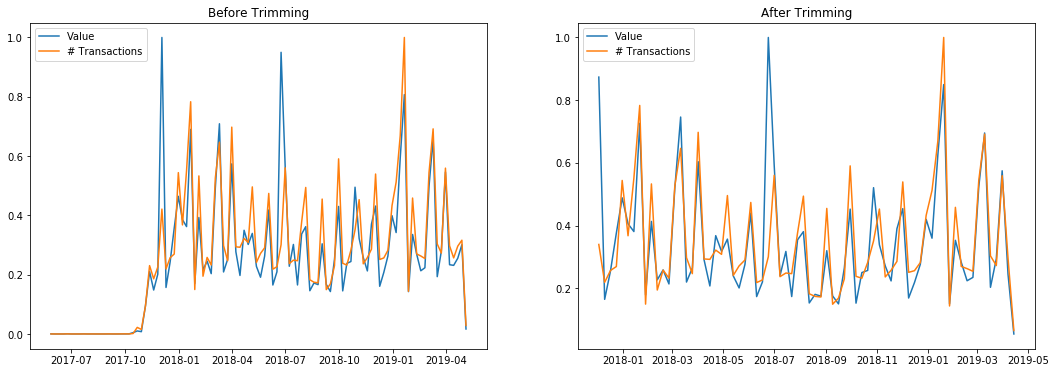

In [5]:
#Time Series data has anomalous data in the beggining and end.
#Therefore it is trimmed, 3/4 months before and 6 months after
#This only corresponds to a loss of about 7% of the samples

subset = data.set_index('DUE_DATE')
time_value = subset.resample('W').VALUE_EUR.sum()
time_t = subset.resample('W').VALUE_EUR.count()
time_value=time_value/time_value.max()
time_t=time_t/time_t.max()

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,6))

ax1.plot(time_value.index, time_value,label="Value")
ax1.plot(time_t.index, time_t,label='# Transactions')
ax1.legend()
ax1.set_title("Before Trimming")
init_length = len(subset)

new_subset = subset[(subset.index >= np.datetime64('2017-11-30'))&(subset.index <= np.datetime64('2019-04-10'))]

time_value = new_subset.resample('W').VALUE_EUR.sum()
time_t = new_subset.resample('W').VALUE_EUR.count()
time_value=time_value/time_value.max()
time_t=time_t/time_t.max()

ax2.plot(time_value.index, time_value,label="Value")
ax2.plot(time_t.index, time_t,label='# Transactions')
ax2.legend()
ax2.set_title("After Trimming")
final_length = len(new_subset)

label_r = ((init_length-final_length)/init_length)*100

print('Percentage samples removed: ' + str(np.round(label_r,4)) +'%')

# Value received and transactions are highly correlated
# Makes sense since if more transactions are made generally more money is transfered

In [6]:
#Trim data set
date_indexed_data = data.reset_index().set_index('PAYMENT_DATE')
did = date_indexed_data
subset = did[(did.index >= np.datetime64('2017-11-30'))&(did.index <= np.datetime64('2019-04-10'))]
data = subset.reset_index().set_index('index')

In [7]:
df = data
df['PAY_RATING']=0
df.loc[df['PAYMENT_DATE'].dt.month < df['DUE_DATE'].dt.month, 'PAY_RATING'] = 1
df.loc[df['PAYMENT_DATE'].dt.month > df['DUE_DATE'].dt.month, 'PAY_RATING'] = -1
df.loc[df['PAYMENT_DATE'].dt.year < df['DUE_DATE'].dt.year, 'PAY_RATING'] = 1
df.loc[df['PAYMENT_DATE'].dt.year > df['DUE_DATE'].dt.year, 'PAY_RATING'] = -1
# df['PAY_RATING']

pay_map ={0:'OnTime',1:'UpFront',-1:'Delayed'}

,PAY_RATING,Name
0,68.590280,OnTime
-1,19.011753,Delayed
1,12.397967,UpFront


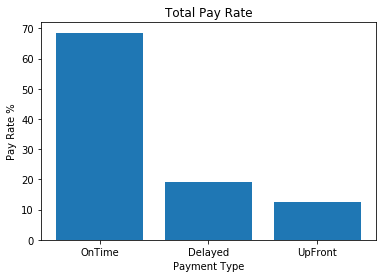

In [8]:
l = len(data['PAY_RATING'])
pay_rate = ((data['PAY_RATING'].value_counts()/l))
pay_df = pd.DataFrame(pay_rate)*100
pay_df['Name']= pay_rate.index.map(lambda x: pay_map[x])
display(pay_df)

plt.bar(pay_df.Name.values,pay_df.PAY_RATING)
plt.title('Total Pay Rate')
plt.xlabel('Payment Type')
plt.ylabel('Pay Rate %')
plt.show()

#Conclusions
# ~68% of people pay on time
# ~19% pay Delayed
# ~12% pay UpFront

In [9]:
def discrete_analysis(field,data,thresh=20,fig_size_=(8,6),show=True):
    if show:
        fig = plt.figure(figsize=fig_size_)
    subset = data[~data[field].isnull()]

    subset_l = subset[field].value_counts()
    subset_l[subset_l<thresh] = np.nan
    subset_l = subset_l.dropna()

    nan_subset = data[~data[field].isin(subset_l.index)]

    group_df=pd.DataFrame(index = subset_l.index)
    values=pd.DataFrame(index = subset_l.index)
    for value in [-1,0,1]:
        value_slice = subset[subset['PAY_RATING']==value][field].value_counts()
        value_slice = value_slice.divide(subset_l)
        value_slice = value_slice.dropna()
        group_df[value]=value_slice
        if show:
            plt.scatter(value_slice.index,value_slice.values*100,label=pay_map[value],linewidths=4,alpha=0.8)

    if show:
        plt.legend()
        plt.title('Pay Rate vs '+ field + ' account')
        plt.xlabel(field)
        plt.ylabel('Pay Rate %')
        plt.show()

    # display(subset_l.sort_index())
    
    nan_percentage =np.round((len(nan_subset)/len(data)),2)*100

    if nan_percentage>0.1:
        nan_dist = nan_subset['PAY_RATING'].value_counts()/len(nan_subset)
        total_dist = data['PAY_RATING'].value_counts()/len(data)

        if show:
            sns.distplot(nan_subset['PAY_RATING'],bins=3,kde_kws={'bw':0.25},label='nan')
            sns.distplot(data['PAY_RATING'],bins=3,kde_kws={'bw':0.25},label='total dist')
            plt.legend()
            plt.title('Nan Distribution vs Total Distribution')
            plt.show()
            print('nan values percentage: ' + str(nan_percentage))
        
    return group_df.fillna(0)

In [10]:
def discrete_cluster(df, k_param=4,n_init_=10,show=True):
    group_values = df.copy()
#Using the elbow method to find the optimum number of clusters
    wcss = []
    X=group_values.values
    for i in range(1,6):
        km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=n_init_, random_state=0)
        km.fit(X)
        wcss.append(km.inertia_)
    if show:
        plt.plot(range(1,6),wcss)
        plt.title('Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('wcss Error')
        plt.show()

    ##Fitting kmeans to the dataset with k=4
    km4=KMeans(n_clusters=k_param,init='k-means++', max_iter=300, n_init=n_init_, random_state=0)
    y_means = km4.fit_predict(X)

    group_values['cluster']=y_means
    
    if show:
        for cluster_id in np.sort(group_values['cluster'].unique()):
            slice_ = group_values[group_values['cluster']==cluster_id].sort_index()
            for col in [-1,0,1]:
                plt.scatter(slice_[col].index,slice_[col].values*100,label=pay_map[col])  
            plt.legend()
            plt.ylabel('Pay Rate %')
            plt.title('Cluster ' + str(cluster_id))
            plt.show()
    return group_values

In [11]:
data.columns

Index(['PAYMENT_DATE', 'MANDT', 'BUKRS', 'GJAHR', 'HKONT', 'KUNNR', 'PRCTR',
       'KNA1_LAND1', 'KNA1_ORT01', 'ZTERM', 'DUE_DATE_SOURCE', 'VALUE_EUR',
       'MWSTS', 'MWST2', 'BLART', 'T003T_LTEXT', 'TBSLT_LTEXT', 'MANSP',
       'CTLPC', 'HISTORICRATING', 'CURRENTRATING', 'DATUM', 'DUE_DATE',
       'GJAHR2', 'DOCUMENT_DATE', 'PAY_RATING'],
      dtype='object')

In [12]:
display(data['MANDT'].unique())

#Repeated value, provides no additional info
data = data.drop('MANDT',axis=1)

array([310], dtype=int64)

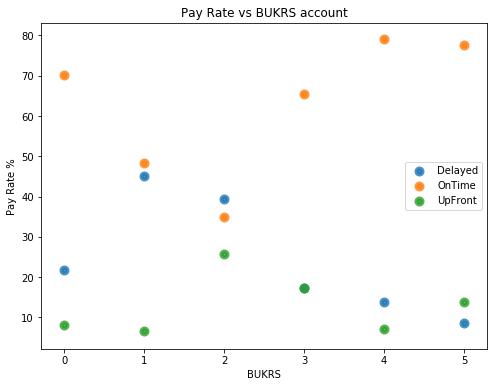

In [13]:
values_group = discrete_analysis('BUKRS',data)

#Very Little info
# only label 2 has a different behaviour
data = data.drop('BUKRS',axis=1)

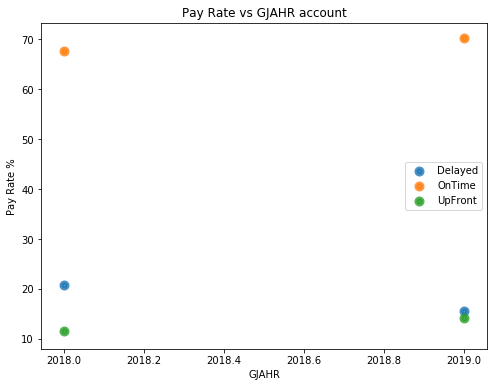

In [14]:
values_group = discrete_analysis('GJAHR',data)

#No additional Info
data = data.drop('GJAHR',axis=1)

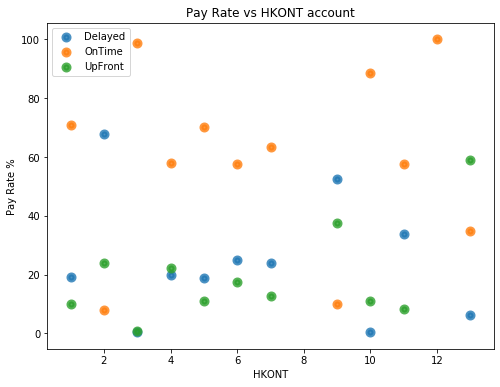

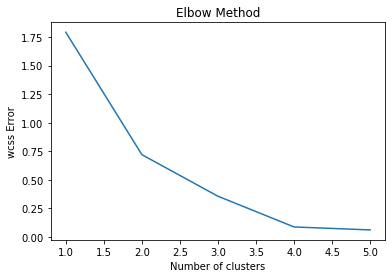

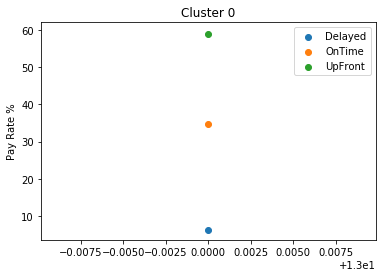

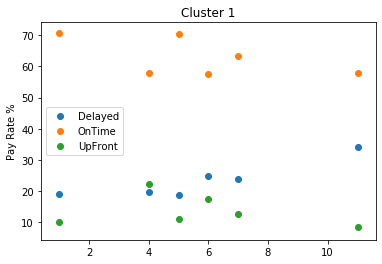

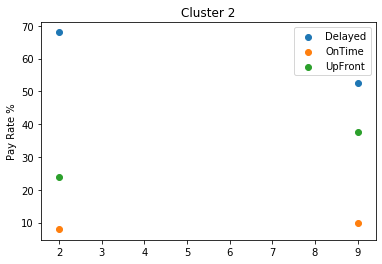

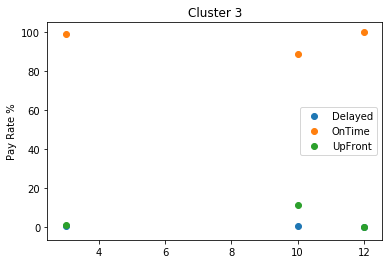

In [15]:
group_values = discrete_analysis('HKONT',data)

# Has three labels with different info

group_cluster = discrete_cluster(group_values,k_param=4)

#Cluster analysis reveals that while most accounts are paid OnTime, as expected
# 2 accounts (cluster 2) are paid mostly Delayed
# 1 account (cluster 0) is paid mostly upfront
# 3 accounts are very highly paid OnTime
# The rest is similar to the Total Distribution (with the OnTime ratio around 70%)

In [16]:
# group_values = discrete_analysis('KUNNR',data)
#customer id

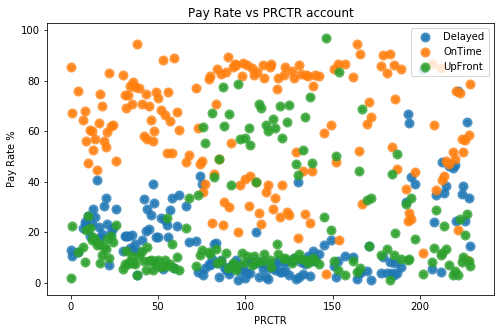

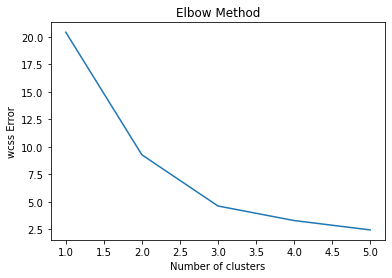

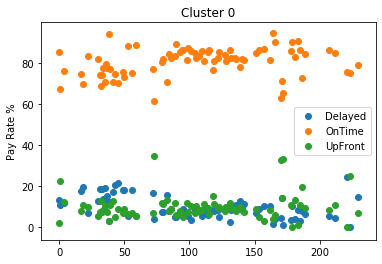

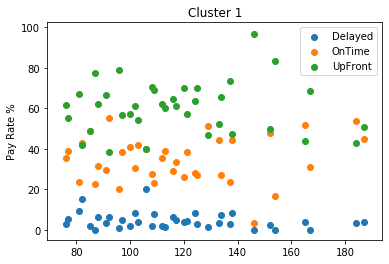

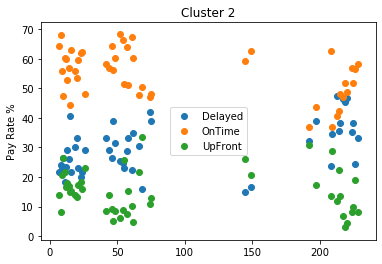

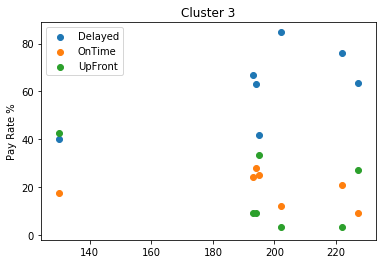

In [17]:
group_values = discrete_analysis('PRCTR',data,fig_size_=(8,5))

group_cluster = discrete_cluster(group_values,k_param=4)

#Clustering reveals interesting features
# C0 (cluster 0) has a similar high ratio of OnTime and UpFront, and a very low one of Delayed
# C1 has a high ratio of OnTime
# C2 has a high ratio of Delayed
# C3 has a high ratio of UpFront
# C4 as a medium to high ratio of OnTime

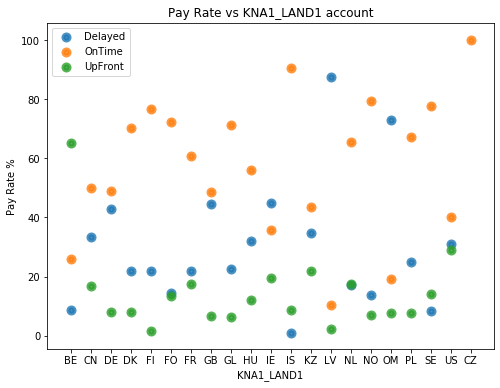

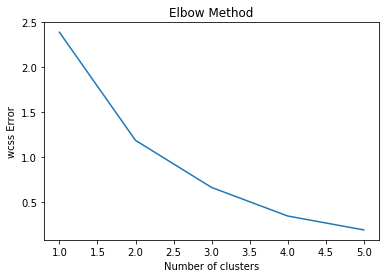

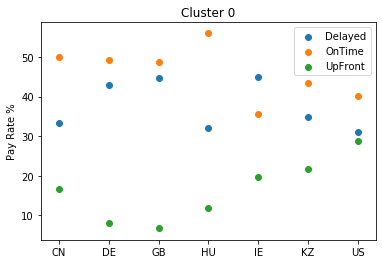

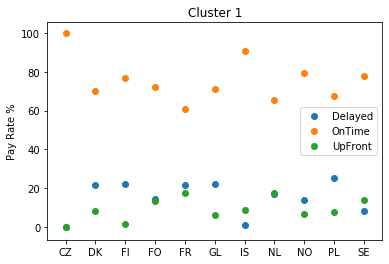

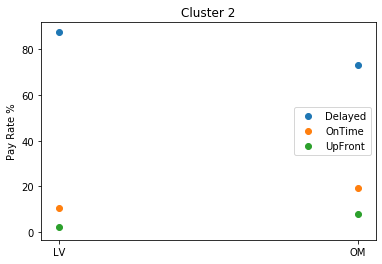

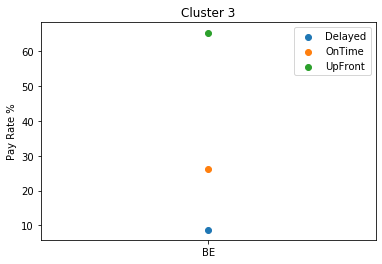

In [18]:
group_values = discrete_analysis('KNA1_LAND1',data)

group_cluster = discrete_cluster(group_values,k_param=4)

#C0 has high ratio of OnTime and Delayed, and low UpFront
#C1 has a high ration OnTime
#C2 has a high ration Delayed
#C3 has a high ratio upfront

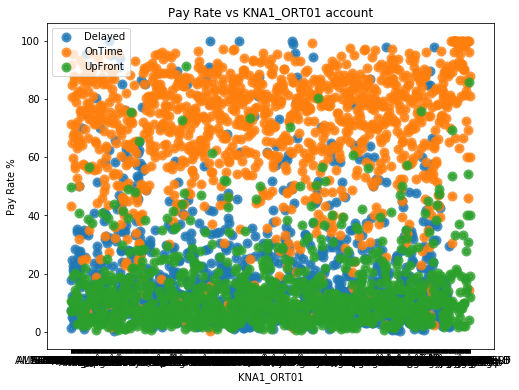

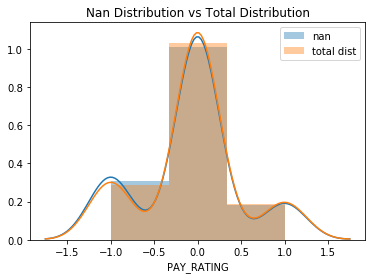

nan values percentage: 5.0


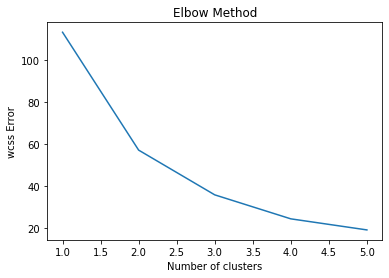

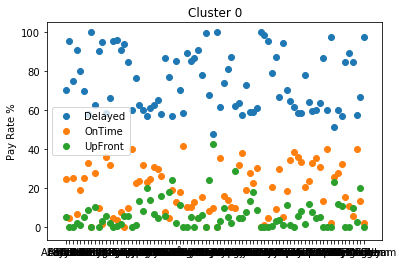

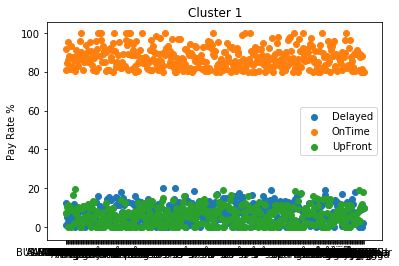

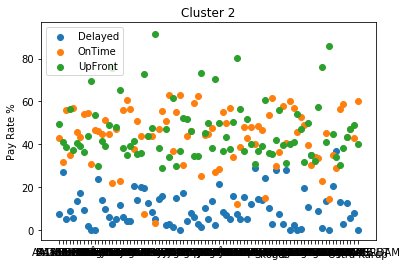

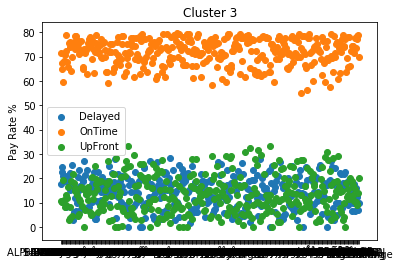

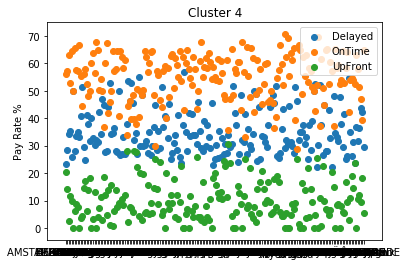

In [19]:
group_values = discrete_analysis('KNA1_ORT01',data)

group_cluster = discrete_cluster(group_values,k_param=5)

#C1 and C3 are predominantly OnTime
#C0 has Low UpFront
#C2 has high Delayed
#C4 has low Delayed

#KNA1_ORT01 represents cities and KNA1_LAND1 represents lands
#Since cities provide more granularity and more detail
# And both are probably correlated
#KNA1_LAND1 will be removed, since KNA1_LAND1 provides better info

data = data.drop('KNA1_LAND1',axis=1)

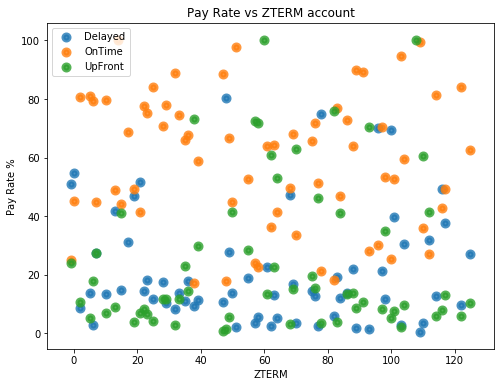

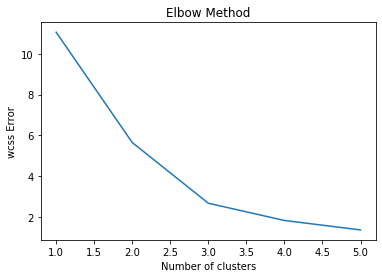

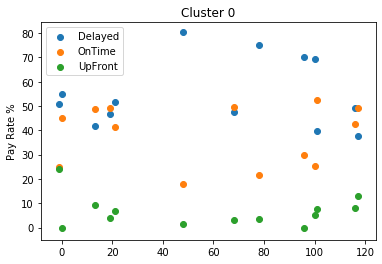

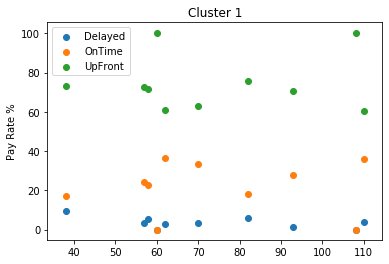

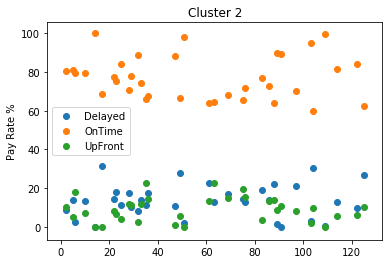

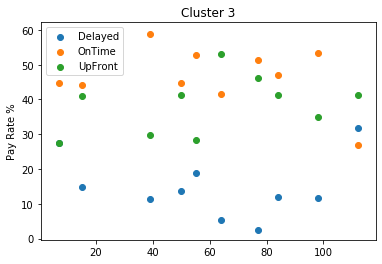

In [20]:
group_values = discrete_analysis('ZTERM',data)

group_cluster = discrete_cluster(group_values,k_param=4)

#C0 has motly delayed
#C1 has mostly UpFront
#C2 has mostly OnTime
#C3 has leastly Delayed

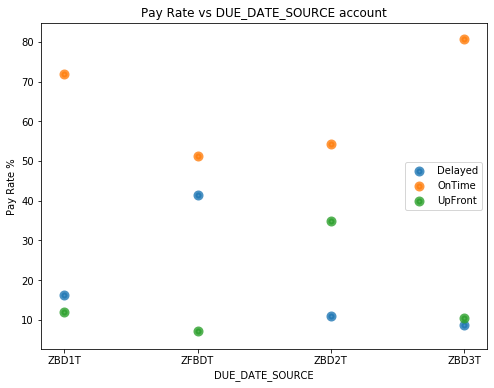

In [21]:
group_values = discrete_analysis('DUE_DATE_SOURCE',data)

#Ontime is highly predominant
# very little info (at most that on label ZFBDT has low UpFront)
#Thus Delete field

data = data.drop('DUE_DATE_SOURCE',axis = 1)

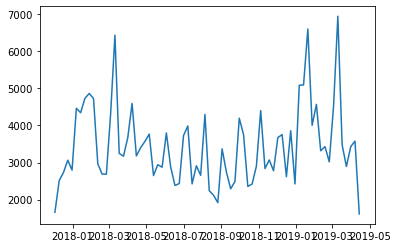

In [22]:
subset = data.reset_index().set_index('PAYMENT_DATE')
counts = subset.resample('W').count().iloc[:,0]

plt.plot(counts.index,counts)
plt.show()


count    247347.000000
mean        187.733755
std        1323.491946
min           0.000000
25%          10.000000
50%          33.000000
75%         100.000000
max      267513.000000
Name: VALUE_EUR, dtype: float64

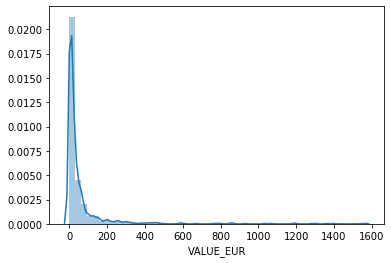

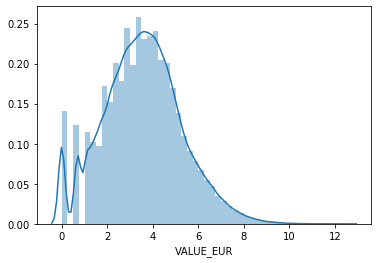

'Percentage of zero values : 1.98 %'

In [23]:
#Value is a continuos variable
#Highly correlated with number of transactions
# pd.qcut(data['VALUE_EUR'],20)
display(data['VALUE_EUR'].describe())

subset = data[data['VALUE_EUR']!= 0]
zero_values = (len(data[data['VALUE_EUR']== 0])/ len(data))*100
# display('Number of zero values:' + str(zero_values))

sns.distplot(subset['VALUE_EUR'][:1000])
plt.show()
#Highly Right skewed
#Maybe log Transformation will help

sns.distplot(np.log(subset['VALUE_EUR']))
plt.show()
display('Percentage of zero values : ' + str(round(zero_values,2)) + ' %')
#Better

index
0    (6.0, 8.0]
1           nan
2    (2.0, 3.0]
3    (3.0, 5.0]
4    (3.0, 5.0]
Name: VALUE_EUR, dtype: object

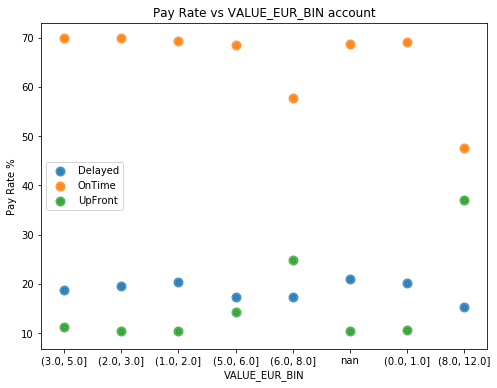

In [24]:
#Next we divide the prices in 7 categories
cut_bins = [0, 1, 2, 3, 5, 6 , 8, 12 ,14]
binned_df = pd.cut(np.log(subset['VALUE_EUR']), bins=cut_bins).astype(str)
display(binned_df.head())
subset['VALUE_EUR_BIN'] = binned_df
group_values = discrete_analysis('VALUE_EUR_BIN',subset)

# No relevant info is obtained
# Delete column
data = data.drop('VALUE_EUR',axis=1)

count    2.473470e+05
mean     5.384699e+02
std      1.230766e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.750000e+06
Name: MWSTS, dtype: float64

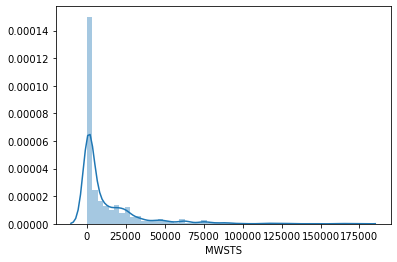

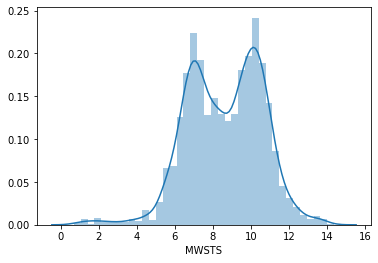

'Percentage of zero values : 98.07 %'

In [25]:
#MWSTS is a continuos variable
# pd.qcut(data['VALUE_EUR'],20)
display(data['MWSTS'].describe())

subset = data[data['MWSTS']!= 0]
zero_values = (len(data[data['MWSTS']== 0])/ len(data))*100

sns.distplot(subset['MWSTS'][:1000])
# plt.title('')
plt.show()
#Highly Right skewed
#Maybe log Transformation will help

sns.distplot(np.log(subset['MWSTS']+1))
plt.show()
display('Percentage of zero values : ' + str(round(zero_values,2)) + ' %')

# 98% have zero value for field
# two peaked distribution after log

index
2733    (0.0, 1.0]
2734    (4.0, 5.0]
2735    (0.0, 1.0]
2736    (1.0, 2.0]
2737    (5.0, 6.0]
Name: MWSTS, dtype: object

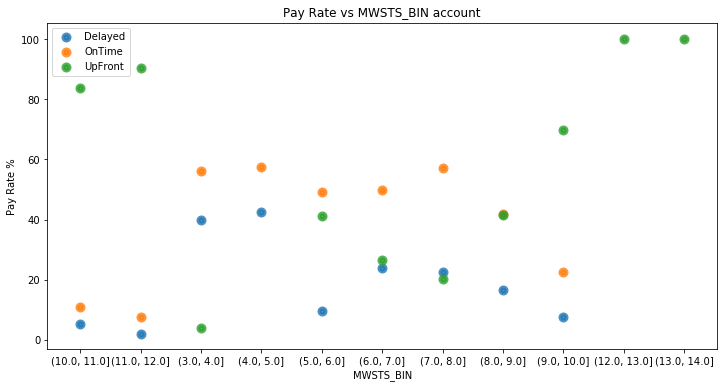

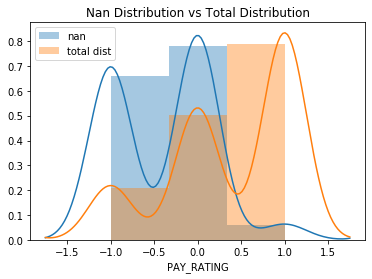

nan values percentage: 1.0


In [26]:
#Next we divide the prices in 7 categories
subset = data[data['MWSTS']!= 0]
cut_bins = range(0,16)
binned_df = pd.cut(np.log(subset['MWSTS']), bins=cut_bins).astype(str)
display(binned_df.head())
subset['MWSTS_BIN'] = binned_df
group_values = discrete_analysis('MWSTS_BIN',subset,fig_size_=(12,6))

#Relevant Info
# 3 labels have high UpFront
# Corresponds to the right peak of the distribution
#Values with high MWSTS value, log(MWSTS) > 9 have high and increasing UpFront
#Create category/ies with these high values


In [27]:
display(data['MWST2'].unique())
#Only one value, delete field
data = data.drop('MWST2',axis = 1)

array([0.])

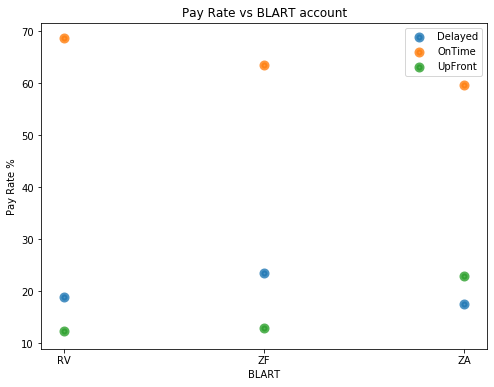

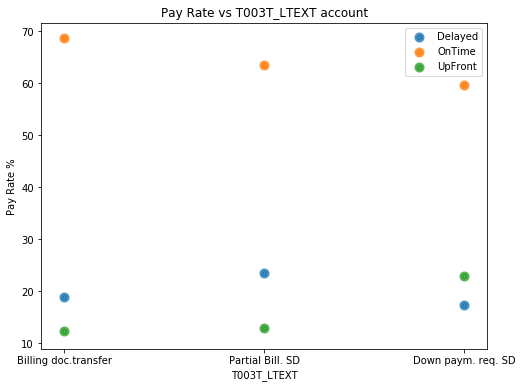

Correlation between BLART and T003T_LTEXT: 0.9999999999999999


In [28]:
from sklearn import preprocessing
values_group = discrete_analysis('BLART',data)
#No Relevant Info
values_group = discrete_analysis('T003T_LTEXT',data)
#Also no relevant info

le_blart = preprocessing.LabelEncoder()
le_blart.fit(data['BLART'])
blart_encoded = le_blart.transform(data['BLART'])

le_t003 = preprocessing.LabelEncoder()
le_t003.fit(data['T003T_LTEXT'])
t003_encoded = le_t003.transform(data['T003T_LTEXT'])

b = pd.Series(blart_encoded)
t = pd.Series(t003_encoded)

print('Correlation between BLART and T003T_LTEXT: '+ str(b.corr(t)))
#They have ~100% correlation
#They represent the same data
#delete both fields

data = data.drop(['BLART','T003T_LTEXT'],axis=1)

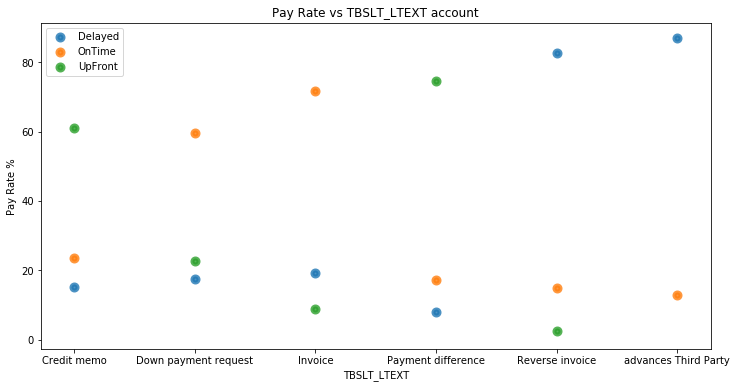

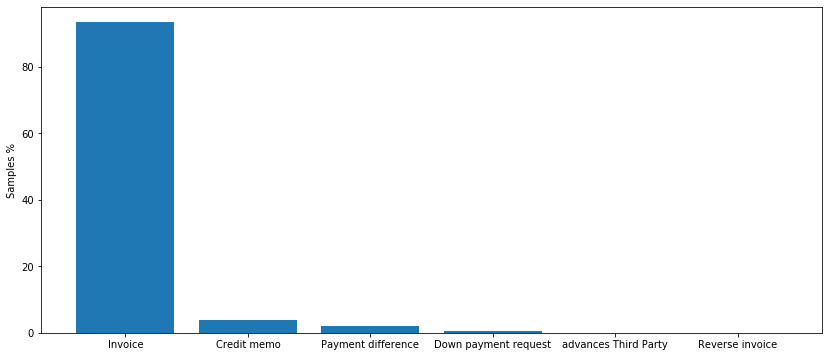

In [29]:
group_values = discrete_analysis('TBSLT_LTEXT',data,fig_size_=(12,6))
# Interesting Info
# Reverse invoice and advances Third Party have high Delayed
# Credit Meno and Payment Difference have high UpFront

counts= data['TBSLT_LTEXT'].value_counts()
counts=counts[counts>20] / len(data['TBSLT_LTEXT'])*100
fig = plt.figure(figsize=(14,6))
plt.bar(counts.index, counts.values)
plt.ylabel('Samples %')
plt.show()
#Almost all payments are by InVoice
# Some are by Credit Memo, Payment Difference and DownPayment Request

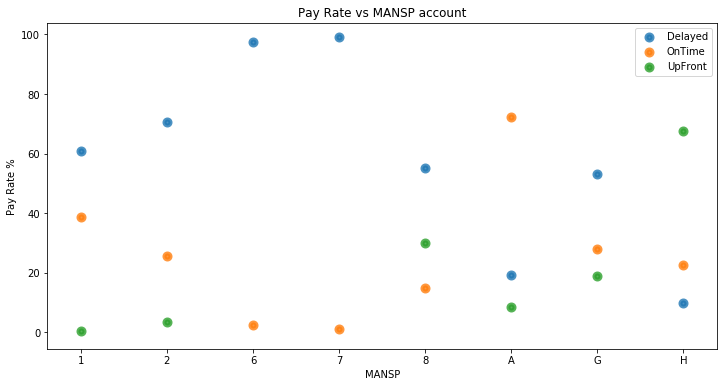

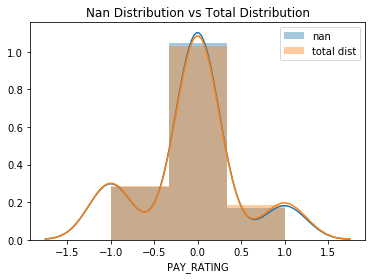

nan values percentage: 97.0


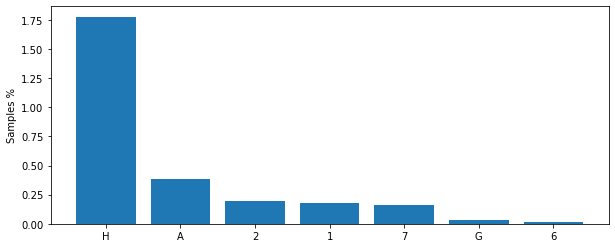

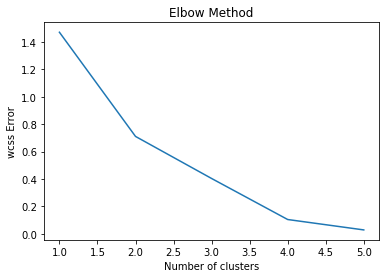

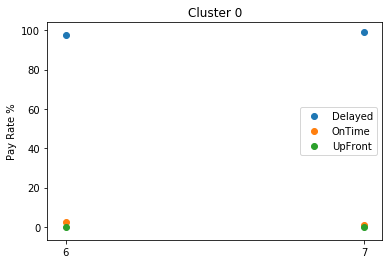

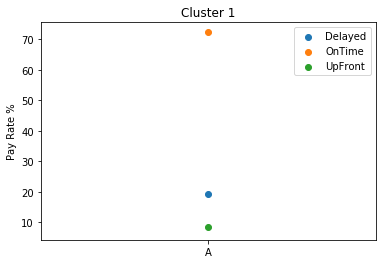

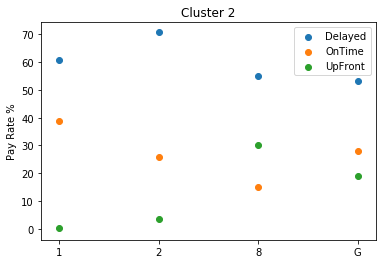

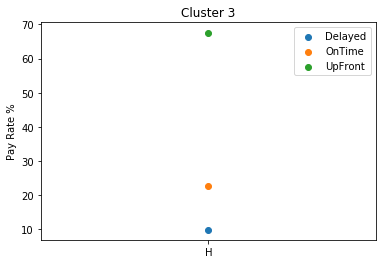

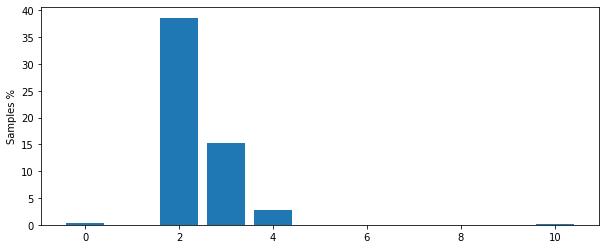

In [30]:
group_values = discrete_analysis('MANSP',data,fig_size_=(12,6))
#97% of MANSP Values are nan

counts= data['MANSP'].value_counts()
counts=counts[counts>20] / len(data['MANSP'])*100
fig = plt.figure(figsize=(10,4))
plt.bar(counts.index, counts.values)
plt.ylabel('Samples %')
plt.show()

group_cluster = discrete_cluster(group_values,k_param=4)

counts= data['CTLPC'].value_counts()
counts=counts[counts>20] / len(data['CTLPC'])*100
fig = plt.figure(figsize=(10,4))
plt.bar(counts.index, counts.values)
plt.ylabel('Samples %')
plt.show()
# C0 has very high Delayed
# C1 has high OnTime
# C2 has high Delayed
# C3 has high UpFront

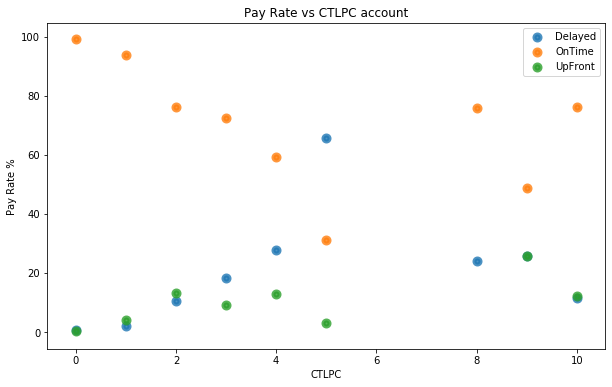

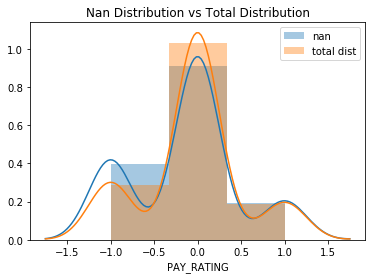

nan values percentage: 43.0


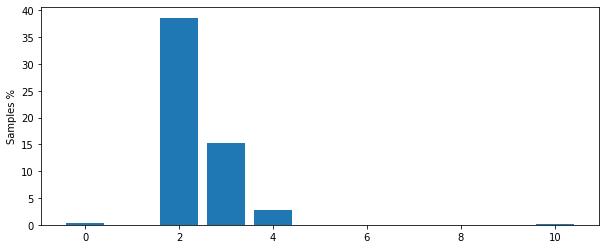

In [31]:
group_values = discrete_analysis('CTLPC',data,fig_size_=(10,6))

counts= data['CTLPC'].value_counts()
counts=counts[counts>20] / len(data['CTLPC'])*100
fig = plt.figure(figsize=(10,4))
plt.bar(counts.index, counts.values)
plt.ylabel('Samples %')
plt.show()

#Little Info, since most of labels have OnTime as high
#The exception is label 5, but it's samples are very low
# Probably a delete

data = data.drop('CTLPC',axis=1)

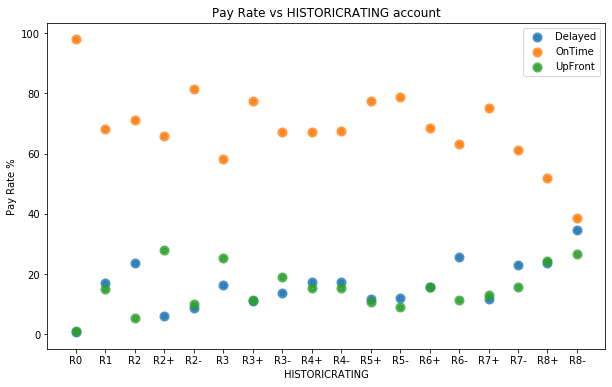

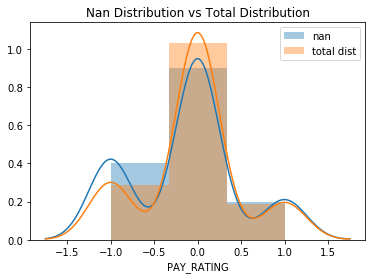

nan values percentage: 41.0


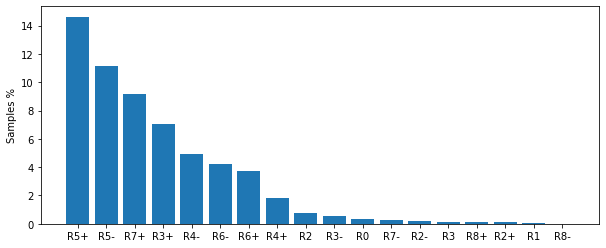

In [32]:
group_values = discrete_analysis('HISTORICRATING',data,fig_size_=(10,6))

counts= data['HISTORICRATING'].value_counts()
counts=counts[counts>20] / len(data['HISTORICRATING'])*100
fig = plt.figure(figsize=(10,4))
plt.bar(counts.index, counts.values)
plt.ylabel('Samples %')
plt.show()

#Little Info, all labels are mostly high 

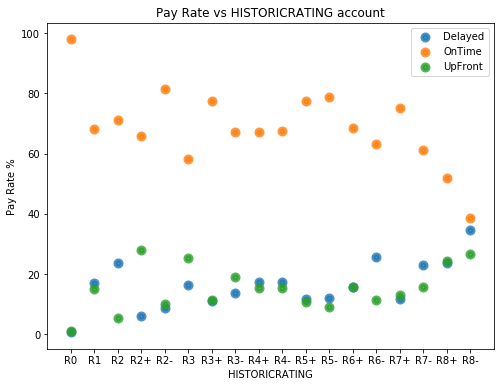

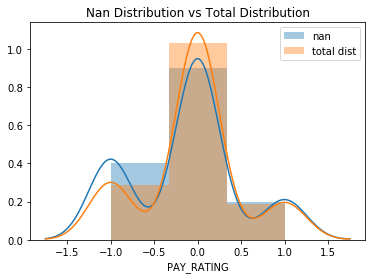

nan values percentage: 41.0


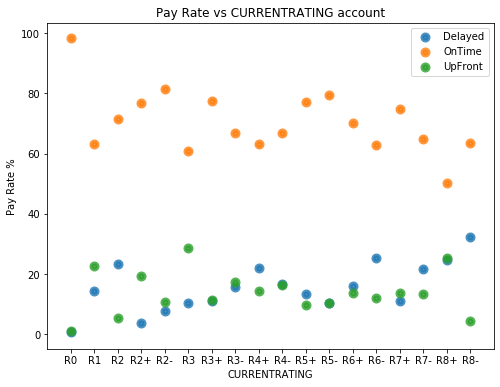

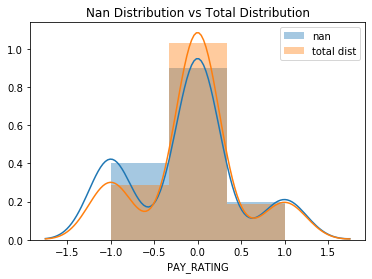

nan values percentage: 41.0
Correlation between CURRENTRATING and HISTORICRATING: 69.0%


In [33]:
values_group = discrete_analysis('HISTORICRATING',data)
#No Relevant Info
values_group = discrete_analysis('CURRENTRATING',data)
#Also no relevant info

before_l = len(data[['CURRENTRATING','HISTORICRATING']].dropna())

same_values = data[['CURRENTRATING','HISTORICRATING']][data['CURRENTRATING']==data['HISTORICRATING']].dropna()

after_l = len(same_values) 

corr =  np.round((after_l/before_l),2)*100

print('Correlation between CURRENTRATING and HISTORICRATING: '+ str(corr) + '%')
# Their correlation is high ~69%
# But the overall distribution is very similar
# Very little valid information to distinguish each label

#50/50 whether to Drop these columns
# data = data.drop(['HISTORICRATING','CURRENTRATING'],axis=1)



In [34]:
#data['DATUM'] means current date at runtime
#delete it
#adds no valuable info
data = data.drop('DATUM',axis = 1)

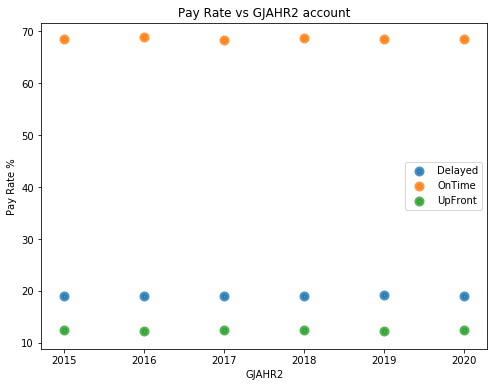

In [35]:
values_group = discrete_analysis('GJAHR2',data)
#No relevant info
#Besides the fact that the distribution of pay rate maintaned constant across the years

data=data.drop('GJAHR2',axis=1)

# Feature Extraction

In [36]:
def create_cluster_feature(field,n_clusters,dataset,feature_set):
    group_values = discrete_analysis(field ,dataset,show=False)
    group_cluster = discrete_cluster(group_values,k_param=n_clusters,show = False)
    for i in range(0,n_clusters):
        cluster_index = group_cluster[group_cluster['cluster']==i].index
        feature_set[field+'_C'+str(i)] = dataset[field].isin(cluster_index).astype(int)
    return feature_set

,KNA1_ORT01,PAY_RATING,KNA1_ORT01_C0,KNA1_ORT01_C1,KNA1_ORT01_C2,KNA1_ORT01_C3,KNA1_ORT01_C4,KNA1_ORT01_C5
index,,,,,,,,
0,KATWIJK,-1,0,0,0,0,1,0
1,WARNSVELD,0,0,0,0,0,0,1
2,OSS,-1,0,1,0,0,0,0
3,KATWIJK,0,0,0,0,0,1,0
4,OSS,0,0,1,0,0,0,0


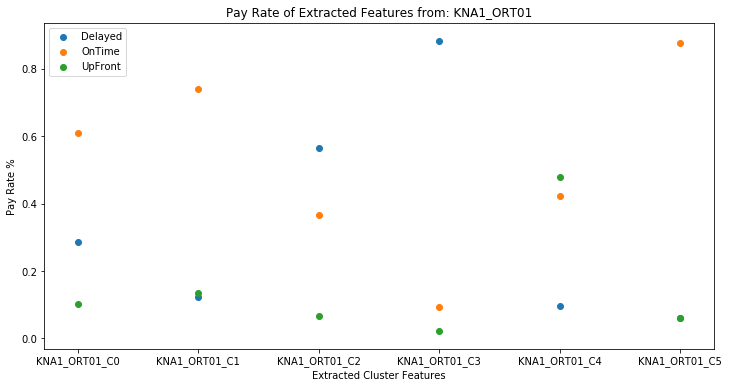

In [37]:
group_values = discrete_analysis('KNA1_ORT01',data,show=False)
group_cluster = discrete_cluster(group_values,k_param=6,show = False)

field = 'KNA1_ORT01'
subset=data[[field,'PAY_RATING']].copy()

for i in range(0,6):
    cluster_index = group_cluster[group_cluster['cluster']==i].index
    subset[field+'_C'+str(i)]=data[field].isin(cluster_index).astype(int)
display(subset.head())

#Check if correct
#'KATWIJK'in group_cluster[group_cluster['cluster']==4].index

subsubset = subset.drop('KNA1_ORT01',axis=1).copy()
fig = plt.figure(figsize=(12,6))

for pay_rate in [-1,0,1]:               
    feature = subsubset[(subsubset['PAY_RATING']==pay_rate)]
    pct = feature.sum()[1:].divide(subsubset.sum()[1:])
    plt.scatter(pct.index,pct.values,label=pay_map[pay_rate])
    
plt.ylabel('Pay Rate %')
plt.xlabel('Extracted Cluster Features')
plt.legend()
plt.title('Pay Rate of Extracted Features from: ' + field)
plt.show()

,HKONT,PAY_RATING,HKONT_C0,HKONT_C1,HKONT_C2,HKONT_C3
index,,,,,,
0,11,-1,0,1,0,0
1,11,0,0,1,0,0
2,11,-1,0,1,0,0
3,11,0,0,1,0,0
4,11,0,0,1,0,0


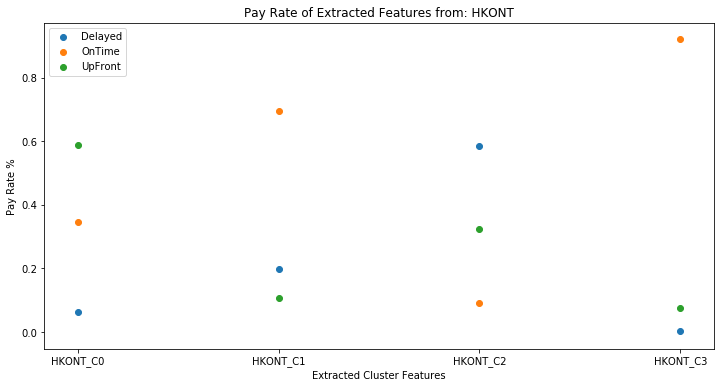

In [38]:
field = 'HKONT'
n_clusters = 4

group_values = discrete_analysis(field ,data,show=False)
group_cluster = discrete_cluster(group_values,k_param=n_clusters,show = False)

subset=data[[field,'PAY_RATING']].copy()

for i in range(0,n_clusters):
    cluster_index = group_cluster[group_cluster['cluster']==i].index
    subset[field+'_C'+str(i)]=data[field].isin(cluster_index).astype(int)
display(subset.head())

subsubset = subset.drop(field,axis=1).copy()
fig = plt.figure(figsize=(12,6))

for pay_rate in [-1,0,1]:               
    feature = subsubset[(subsubset['PAY_RATING']==pay_rate)]
    pct = feature.sum()[1:].divide(subsubset.sum()[1:])
    plt.scatter(pct.index,pct.values,label=pay_map[pay_rate])
    
plt.ylabel('Pay Rate %')
plt.xlabel('Extracted Cluster Features')
plt.legend()
plt.title('Pay Rate of Extracted Features from: ' + field)
plt.show()

,PRCTR,PAY_RATING,PRCTR_C0,PRCTR_C1,PRCTR_C2,PRCTR_C3
index,,,,,,
0,1,-1,1,0,0,0
1,1,0,1,0,0,0
2,1,-1,1,0,0,0
3,1,0,1,0,0,0
4,1,0,1,0,0,0


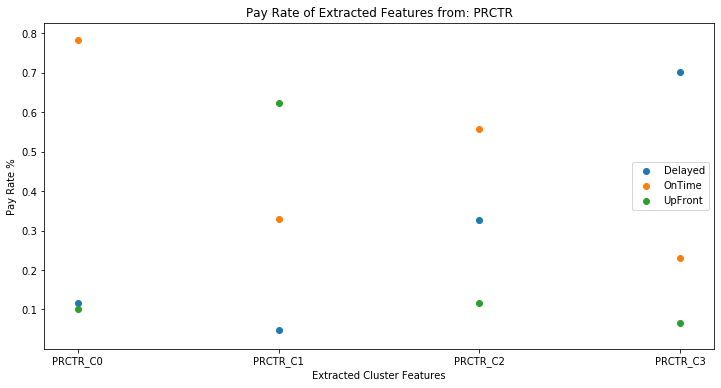

In [39]:
field = 'PRCTR'
n_clusters = 4

group_values = discrete_analysis(field ,data,show=False)
group_cluster = discrete_cluster(group_values,k_param=n_clusters,show = False)

subset=data[[field,'PAY_RATING']].copy()

for i in range(0,n_clusters):
    cluster_index = group_cluster[group_cluster['cluster']==i].index
    subset[field+'_C'+str(i)]=data[field].isin(cluster_index).astype(int)
display(subset.head())

#Check if correct
#'KATWIJK'in group_cluster[group_cluster['cluster']==4].index

subsubset = subset.drop(field,axis=1).copy()
fig = plt.figure(figsize=(12,6))

for pay_rate in [-1,0,1]:               
    feature = subsubset[(subsubset['PAY_RATING']==pay_rate)]
    pct = feature.sum()[1:].divide(subsubset.sum()[1:])
    plt.scatter(pct.index,pct.values,label=pay_map[pay_rate])
    
plt.ylabel('Pay Rate %')
plt.xlabel('Extracted Cluster Features')
plt.legend()
plt.title('Pay Rate of Extracted Features from: ' + field)
plt.show()

In [40]:
feature_set = data[['PAY_RATING']].copy()
feature_set = create_cluster_feature(field = 'KNA1_ORT01', n_clusters = 6, dataset = data, feature_set = feature_set)
feature_set = create_cluster_feature(field = 'HKONT', n_clusters = 4, dataset = data, feature_set = feature_set)
feature_set = create_cluster_feature(field = 'KUNNR', n_clusters = 4, dataset = data, feature_set = feature_set)
feature_set.head()

,PAY_RATING,KNA1_ORT01_C0,KNA1_ORT01_C1,KNA1_ORT01_C2,KNA1_ORT01_C3,KNA1_ORT01_C4,KNA1_ORT01_C5,HKONT_C0,HKONT_C1,HKONT_C2,HKONT_C3,KUNNR_C0,KUNNR_C1,KUNNR_C2,KUNNR_C3
index,,,,,,,,,,,,,,,
0,-1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
2,-1,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


index
0    nan
1    nan
2    nan
3    nan
4    nan
Name: MWSTS, dtype: object

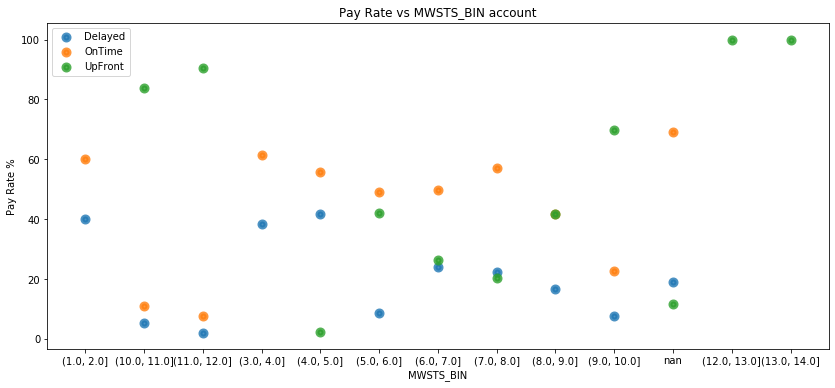

In [41]:
# subset = data[data['MWSTS']!= 0]
subset = data.copy()
cut_bins = range(0,16)
binned_df = pd.cut(np.log(subset['MWSTS']+1), bins=cut_bins).astype(str)
display(binned_df.head())
subset['MWSTS_BIN'] = binned_df
group_values = discrete_analysis('MWSTS_BIN',subset,fig_size_=(14,6))

subset_MWSTS = subset.copy()

In [42]:
# Model Training and CrossValidation

In [43]:
import warnings
warnings.filterwarnings("ignore")

from statistics import mean
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
import statistics as stats

In [44]:
data.columns

#Analyse by Due Date

Index(['PAYMENT_DATE', 'HKONT', 'KUNNR', 'PRCTR', 'KNA1_ORT01', 'ZTERM',
       'MWSTS', 'TBSLT_LTEXT', 'MANSP', 'HISTORICRATING', 'CURRENTRATING',
       'DUE_DATE', 'DOCUMENT_DATE', 'PAY_RATING'],
      dtype='object')

In [45]:
feature_set = data[['PAY_RATING']].copy()
feature_set = create_cluster_feature(field = 'HKONT', n_clusters = 4, dataset = data, feature_set = feature_set)
feature_set = create_cluster_feature(field = 'KUNNR', n_clusters = 4, dataset = data, feature_set = feature_set)
feature_set = create_cluster_feature(field = 'PRCTR', n_clusters = 4, dataset = data, feature_set = feature_set)
feature_set = create_cluster_feature(field = 'KNA1_ORT01', n_clusters = 6, dataset = data, feature_set = feature_set)
feature_set = create_cluster_feature(field = 'ZTERM', n_clusters = 4, dataset = data, feature_set = feature_set)
feature_set = create_cluster_feature(field = 'TBSLT_LTEXT', n_clusters = 4, dataset = data, feature_set = feature_set)
feature_set = create_cluster_feature(field = 'MANSP', n_clusters = 4, dataset = data, feature_set = feature_set)
feature_set = create_cluster_feature(field = 'MWSTS_BIN', n_clusters = 4, dataset = subset_MWSTS, feature_set = feature_set)
feature_set = create_cluster_feature(field = 'CURRENTRATING', n_clusters = 4, dataset = data, feature_set = feature_set)

# feature_set = create_cluster_feature(field = 'MANSP', n_clusters = 4, dataset = data, feature_set = feature_set)

In [46]:
print('More significant features')
display(feature_set.corr().iloc[:,0][1:].abs().nlargest(10))
print('Less significant features')
display(feature_set.corr().iloc[:,0][1:].abs().nsmallest(10))


More significant features


KUNNR_C2          0.368312
KUNNR_C1          0.281332
ZTERM_C0          0.269434
TBSLT_LTEXT_C1    0.267852
KNA1_ORT01_C3     0.259012
TBSLT_LTEXT_C2    0.257651
PRCTR_C1          0.217574
HKONT_C0          0.203984
HKONT_C1          0.189154
KNA1_ORT01_C2     0.188913
Name: PAY_RATING, dtype: float64

Less significant features


CURRENTRATING_C1    0.001788
MANSP_C1            0.004876
HKONT_C2            0.005692
CURRENTRATING_C2    0.007757
MWSTS_BIN_C2        0.011473
CURRENTRATING_C3    0.017761
TBSLT_LTEXT_C3      0.017878
TBSLT_LTEXT_C0      0.027127
HKONT_C3            0.030048
MWSTS_BIN_C3        0.035696
Name: PAY_RATING, dtype: float64

In [ ]:
#Separating into independent (X) and dependent(Y) variables
X = feature_set.drop(['PAY_RATING'],axis=1).values
y = feature_set.PAY_RATING.values

#Simple train test split
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state = 0)

clf = LogisticRegression(max_iter=50).fit(xTrain, yTrain)
train_predictions = clf.predict(xTest)
acc = accuracy_score(yTest, train_predictions)*100
print('Acc '+ str(round(acc,4)))

# #K-Fold
# print('\nK-Fold')
# kf = KFold(n_splits=5, random_state = 0)
# avg_acc=[]
# for train_index, test_index in kf.split(X):
#     xTrain, yTrain = X[train_index] , y[train_index]
#     xTest, yTest = X[test_index] , y[test_index]
    
#     clf = LogisticRegression().fit(xTrain, yTrain)
#     train_predictions = clf.predict(xTest)
#     acc = accuracy_score(yTest, train_predictions) *100
#     avg_acc.append(acc)
#     print('Acc '+ str(round(acc,4)))
# print('\nAverage Accuracy '+ str(round(mean(avg_acc),5)))
# print('\n1000*STD : '+ str(round(stats.stdev(avg_acc)*1000,3)))

#Shuffle split
print('\nShuffle split')
ss = ShuffleSplit(n_splits=5, random_state=0, test_size=0.2, train_size=None)
avg_acc=[]
for train_index, test_index in ss.split(X):
    xTrain, yTrain = X[train_index] , y[train_index]
    xTest, yTest = X[test_index] , y[test_index]
    
    clf = LogisticRegression().fit(xTrain, yTrain)
    train_predictions = clf.predict(xTest)
    acc = accuracy_score(yTest, train_predictions) *100 
    avg_acc.append(acc)
    print('Acc '+ str(round(acc,4)))
print('\nAverage Accuracy '+ str(round(mean(avg_acc),5)))
# print('\nSTD : '+ str(round(stats.stdev(avg_acc),3)))

# #stratified K-Fold
# print('\nStratified K-Fold')
# skf = StratifiedKFold(n_splits=5, random_state = 0)
# avg_acc=[]
# for train_index, test_index in skf.split(X,y):
#     xTrain, yTrain = X[train_index] , y[train_index]
#     xTest, yTest = X[test_index] , y[test_index]
    
#     clf = LogisticRegression().fit(xTrain, yTrain)
#     train_predictions = clf.predict(xTest)
#     acc = accuracy_score(yTest, train_predictions)  *100
#     avg_acc.append(acc)
#     print('Acc '+ str(acc))
# print('\nAverage Accuracy '+ str(round(mean(avg_acc),5)))
# print('\nSTD : '+ str(round(stats.stdev(avg_acc),3)))

# #Stratified Shuffle split
# print('\nStratified Shuffle split')
# sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
# avg_acc=[]
# for train_index, test_index in sss.split(X,y):
#     xTrain, yTrain = X[train_index] , y[train_index]
#     xTest, yTest = X[test_index] , y[test_index]
    
#     clf = LogisticRegression().fit(xTrain, yTrain)
#     train_predictions = clf.predict(xTest)
#     acc = accuracy_score(yTest, train_predictions)  *100
#     avg_acc.append(acc)
#     print('Acc '+ str(round(acc,4)))
# print('\nAverage Accuracy '+ str(round(mean(avg_acc),5)))
# print('\nSTD : '+ str(round(stats.stdev(avg_acc),3)))

Acc 77.3721

Shuffle split
Acc 77.4186
Acc 77.5702
Acc 77.1417
Acc 77.3641


In [ ]:
# The End:  77% accuracy